In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename="/data/afarbin/DLClass/SUSY/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi"]
FeatureNames=[ "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]

df = pd.read_csv(filename, dtype='float64', names=VarNames)



Now lets define training and test samples. Note that DNNs take very long to train, so for testing purposes we will use only about 10% of the 5 million events in the training/validation sample. Once you get everything working, make the final version of your plots with the full sample. 

Also note that Keras had trouble with the Pandas tensors, so after doing all of the nice manipulation that Pandas enables, we convert the Tensor to a regular numpy tensor.

In [2]:
#N_Max=550000
N_Max=5000000 
N_Train=500000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:N_Max]

X_Train=np.array(Train_Sample[VarNames[1:]])
y_Train=np.array(Train_Sample["signal"])

X_Test=np.array(Test_Sample[VarNames[1:]])
y_Test=np.array(Test_Sample["signal"])


Now lets setup everything. Note that you will need to use a GPU to get reasonable training times. The Jupyter server will have up tp 4 GPUs in it. Your Jupyter session is now running through a batch queue system that effectively assigns a GPU to you. Here we tell Keras's backend, Theano, to use the GPU assigned to you.

In [8]:
import os 
print "Using Queue:", os.environ["PBS_QUEUE"]
gpuid=int(os.environ["PBS_QUEUE"][3:4])
print "Using GPU:", gpuid
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=gpu%s,floatX=float32,force_device=True" % (gpuid)

Using Queue: gpu3super_ipynb
Using GPU: 3


There was some problem getting the profiler to work in this notebook, so we turn it off: 

In [9]:
import theano
theano.config.profile=False

AttributeError: 'module' object has no attribute 'tests'

Now we will build a simple model, as described in class. Note that this is very small model, so things run fast. You should attempt more ambitious models.

In [10]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(12, input_dim=X_Train.shape[1], kernel_initializer="random_uniform", activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="random_uniform", activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="random_uniform", activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,kernel_initializer="random_uniform", activation='sigmoid'))

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/__init__.py", line 61, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
ImportError: libcudart.so.8.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/get_started/os_setup.md#import_error

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 12)                228       
_________________________________________________________________
dropout_10 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 64)                832       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total para

Now we train. We are running only 10 epochs in this example. Models may need hundreds of epochs before they stop improving.

In [58]:
history=model.fit(X_Train, y_Train, validation_data=(X_Test,y_Test), epochs=30, batch_size=2048)

Train on 500000 samples, validate on 4500000 samples
Epoch 1/30
500000/500000 [==============================] - 11s - loss: 0.5239 - acc: 0.7481 - val_loss: 0.4579 - val_acc: 0.7883
Epoch 2/30
500000/500000 [==============================] - 10s - loss: 0.4704 - acc: 0.7862 - val_loss: 0.4544 - val_acc: 0.7894
Epoch 3/30
500000/500000 [==============================] - 10s - loss: 0.4674 - acc: 0.7864 - val_loss: 0.4527 - val_acc: 0.7902
Epoch 4/30
500000/500000 [==============================] - 10s - loss: 0.4661 - acc: 0.7860 - val_loss: 0.4522 - val_acc: 0.7897
Epoch 5/30
500000/500000 [==============================] - 10s - loss: 0.4645 - acc: 0.7864 - val_loss: 0.4516 - val_acc: 0.7904
Epoch 6/30
500000/500000 [==============================] - 10s - loss: 0.4640 - acc: 0.7860 - val_loss: 0.4514 - val_acc: 0.7903
Epoch 7/30
500000/500000 [==============================] - 10s - loss: 0.4635 - acc: 0.7858 - val_loss: 0.4511 - val_acc: 0.7907
Epoch 8/30
500000/500000 [===========

The model history keeps track of the loss and accuracy for each epoch. Note that the training above was setup to run on the validation sample at the end of each epoch:

In [59]:
print history.history

{'acc': [0.7480739999847412, 0.786216, 0.7863919999923706, 0.785962, 0.7864359999961853, 0.7859979999885559, 0.7857699999885559, 0.78683, 0.786668, 0.7867720000076294, 0.7864759999961853, 0.7870919999847412, 0.787174, 0.787172000011444, 0.7874199999923706, 0.786378, 0.7868700000152588, 0.7875680000038147, 0.7869779999885559, 0.7877700000038147, 0.7873379999847412, 0.787144, 0.7875519999847412, 0.7874159999923706, 0.7876919999885559, 0.787724, 0.7878359999885559, 0.7875120000038147, 0.7871620000152588, 0.7875960000076294], 'loss': [0.5238706009540558, 0.4704377195701599, 0.4673769860267639, 0.4660773541755676, 0.46447597383499145, 0.46397248944664, 0.4634854656639099, 0.46294079195404053, 0.4625333619632721, 0.46261836821937563, 0.46235101033210757, 0.4617877995223999, 0.4621640826320648, 0.461808077419281, 0.4620637383403778, 0.461722564540863, 0.46187357433891296, 0.461256461397171, 0.4617118843307495, 0.46170952057266235, 0.4616242468032837, 0.4617038994789123, 0.4612354748840332, 0.

## Exercise 5.1

You will need to create several models and make sure they are properly trained. Write a function that takes this history and plots the values versus epoch. For every model that you train in the remainder of this lab, assess:

    * Has you model's performance plateaued? If not train for more epochs. 

    * Compare the performance on training versus test sample. Are you over training?

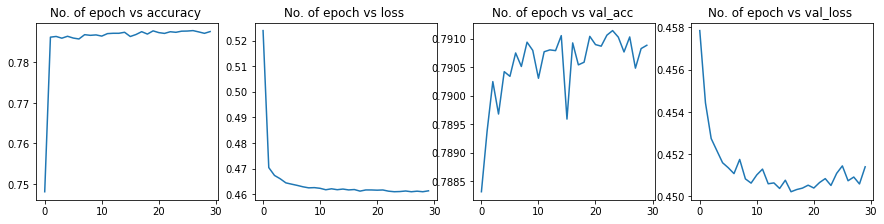

In [60]:

def plot_epoch_acc(his):
    plt.figure("graph",[15,15])
    plt.subplot(4,4,1)
    plt.plot(range(0,len(his.history['acc'])),his.history['acc'])
    plt.title("No. of epoch vs accuracy ")
    plt.subplot(4,4,2)
    plt.plot(range(0,len(his.history['loss'])),his.history['loss'])
    plt.title("No. of epoch vs loss ")
    plt.subplot(4,4,3)
    plt.plot(range(0,len(his.history['val_acc'])),his.history['val_acc'])
    plt.title("No. of epoch vs val_acc " )
    plt.subplot(4,4,4)
    plt.plot(range(0,len(his.history['val_loss'])),his.history['val_loss'])
    plt.title("No. of epoch vs val_loss " )
    
    plt.show()
    
    
plot_epoch_acc(history)



We can evaluate how the trained model does on the test sample as follows:

In [61]:
scores = model.evaluate(X_Test, y_Test)
print scores

4499840/4500000 [============================>.] - ETA: 0s[0.45140260501596663, 0.7908844444444444]


And we can make ROC curves as before:

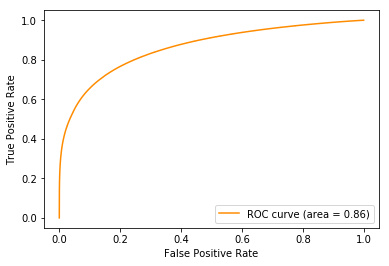

In [62]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, model.predict(X_Test))
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

## Exercise 5.2

Following lab 4, make a comparison of the performance between models trained with raw, features, and raw+features data.

In [15]:
X_Train_Raw=np.array(Train_Sample[VarNames[1:7]])
y_Train_Raw=np.array(Train_Sample["signal"])

X_Test_Raw=np.array(Test_Sample[VarNames[1:7]])
y_Test_Raw=np.array(Test_Sample["signal"])



In [16]:
Raw_model = Sequential()
Raw_model.add(Dense(12, input_dim=X_Train_Raw.shape[1], kernel_initializer='uniform', activation='relu'))
Raw_model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
Raw_model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [17]:
Raw_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Raw_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [18]:

Raw_History=Raw_model.fit(X_Train_Raw,y_Train_Raw,validation_data=(X_Test_Raw,y_Test_Raw),epochs=10, batch_size=2048)


Train on 500000 samples, validate on 50000 samples
Epoch 1/10
500000/500000 [==============================] - 2s - loss: 0.6408 - acc: 0.6271 - val_loss: 0.5698 - val_acc: 0.7190
Epoch 2/10
500000/500000 [==============================] - 1s - loss: 0.5580 - acc: 0.7238 - val_loss: 0.5533 - val_acc: 0.7278
Epoch 3/10
500000/500000 [==============================] - 1s - loss: 0.5523 - acc: 0.7256 - val_loss: 0.5512 - val_acc: 0.7275
Epoch 4/10
500000/500000 [==============================] - 1s - loss: 0.5504 - acc: 0.7260 - val_loss: 0.5493 - val_acc: 0.7287
Epoch 5/10
500000/500000 [==============================] - 1s - loss: 0.5486 - acc: 0.7269 - val_loss: 0.5471 - val_acc: 0.7294
Epoch 6/10
500000/500000 [==============================] - 1s - loss: 0.5468 - acc: 0.7278 - val_loss: 0.5454 - val_acc: 0.7305
Epoch 7/10
500000/500000 [==============================] - 1s - loss: 0.5455 - acc: 0.7284 - val_loss: 0.5441 - val_acc: 0.7308
Epoch 8/10
500000/500000 [====================

In [19]:
scores_raw = Raw_model.evaluate(X_Test_Raw, y_Test_Raw)
print scores_raw

49888/50000 [============================>.] - ETA: 0s[0.5417746139240265, 0.73192]


In [20]:
from sklearn.metrics import roc_curve, auc
fpr_r, tpr_r, _ = roc_curve(y_Test_Raw, Raw_model.predict(X_Test_Raw))
                        
roc_auc_r = auc(fpr_r, tpr_r)


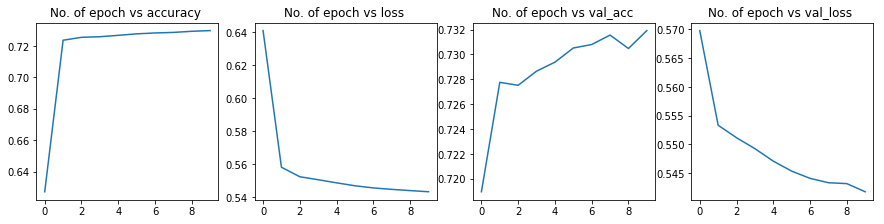

In [21]:
plot_epoch_acc(Raw_History)

In [22]:
X_Train_Feature=np.array(Train_Sample[VarNames[7:]])
y_Train_Feature=np.array(Train_Sample["signal"])

X_Test_Feature=np.array(Test_Sample[VarNames[7:]])
y_Test_Feature=np.array(Test_Sample["signal"])



In [23]:
Feature_model = Sequential()
Feature_model.add(Dense(12, input_dim=X_Train_Feature.shape[1], kernel_initializer='uniform', activation='relu'))
Feature_model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
Feature_model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [24]:
Feature_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________


In [25]:
Feature_History=Feature_model.fit(X_Train_Feature,y_Train_Feature,validation_data=(X_Test_Feature,y_Test_Feature),epochs=10, batch_size=2048)




Train on 500000 samples, validate on 50000 samples
Epoch 1/10
500000/500000 [==============================] - 2s - loss: 0.5882 - acc: 0.7184 - val_loss: 0.4873 - val_acc: 0.7720
Epoch 2/10
500000/500000 [==============================] - 1s - loss: 0.4762 - acc: 0.7777 - val_loss: 0.4771 - val_acc: 0.7764
Epoch 3/10
500000/500000 [==============================] - 2s - loss: 0.4716 - acc: 0.7797 - val_loss: 0.4747 - val_acc: 0.7774
Epoch 4/10
500000/500000 [==============================] - 1s - loss: 0.4697 - acc: 0.7801 - val_loss: 0.4750 - val_acc: 0.7754
Epoch 5/10
500000/500000 [==============================] - 1s - loss: 0.4684 - acc: 0.7806 - val_loss: 0.4720 - val_acc: 0.7785
Epoch 6/10
500000/500000 [==============================] - 1s - loss: 0.4665 - acc: 0.7818 - val_loss: 0.4700 - val_acc: 0.7805
Epoch 7/10
500000/500000 [==============================] - 1s - loss: 0.4647 - acc: 0.7829 - val_loss: 0.4683 - val_acc: 0.7801
Epoch 8/10
500000/500000 [====================

In [26]:
scores_feature = Feature_model.evaluate(X_Test_Feature, y_Test_Feature)
print scores_feature

49888/50000 [============================>.] - ETA: 0s[0.4602012890720367, 0.78304]


In [27]:
from sklearn.metrics import roc_curve, auc
fpr_f, tpr_f, _ = roc_curve(y_Test_Feature, Feature_model.predict(X_Test_Feature))
                        
roc_auc_f = auc(fpr_f, tpr_f)

The plots for feature only 

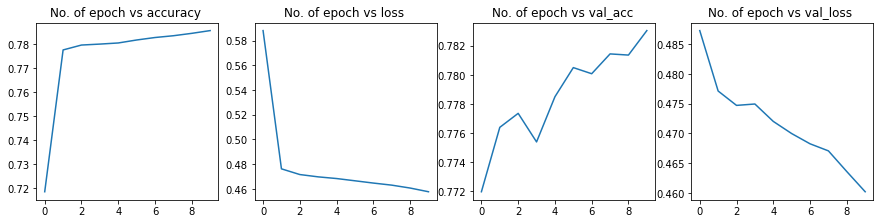

 None
The plots for raw only 

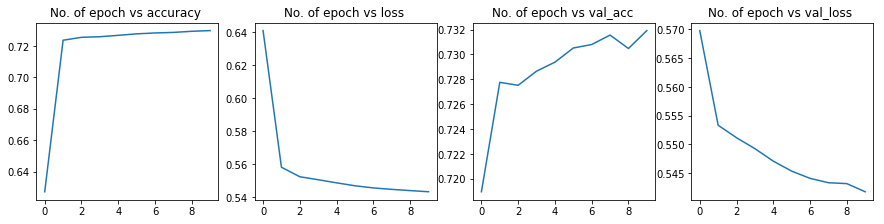

 None
The plots for raw+feature 

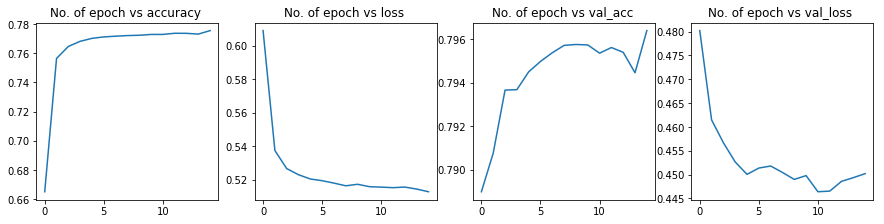

 None


In [28]:
print "The plots for feature only ", plot_epoch_acc(Feature_History)
print "The plots for raw only ", plot_epoch_acc(Raw_History)
print "The plots for raw+feature ", plot_epoch_acc(history)

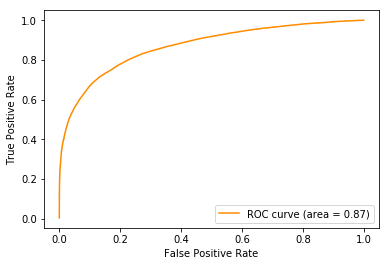

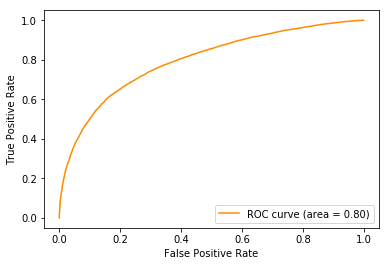

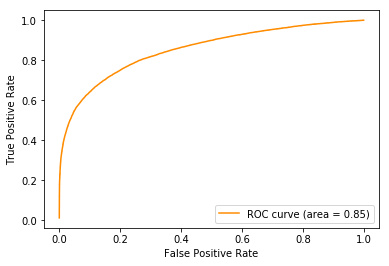

In [29]:
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

roc_auc_r = auc(fpr_r, tpr_r)

plt.plot(fpr_r,tpr_r,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc_r)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

roc_auc = auc(fpr, tpr)

plt.plot(fpr_f,tpr_f,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc_f)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


## Exercise 5.3

Again, following lab 4, design and implement at least 3 different DNN models. Train them and compare performance. You may try different architectures, loss functions, and optimizers to see if there is an effect.

In [ ]:
model_1 = 
model_2 =
model_3 = 


## Honors Problem- Exercise 5.4

Write a function that evaluates the performance (AUC) as a function of a given input variable. You will need to bin the test data in the variable (i.e. make sub-samples for events which have the particular variable in a range), evaluate the performance in each bin, and plot the results.

Apply your function to each input variable.